In [1]:
# -*- coding: utf-8 -*-
'''
Created on Oct 2023

@authors:   Jamie Taylor (CUNEF)
            Manuela Bastidas (UPV/EHU)
            Tomas Teijeiro (BCAM)
            https://www.mathmode.science/
            
Updated on Jan 2025 by:
    Ángel Javier Omella
'''

# This code presents a simple implementation of Physics-Informed
# Neural Networks (PINNs) as a collocation method. -- <50 lines of PINNS--

# In this 1D example, we utilize Keras for constructing neural networks
# and JAX in the backend.


import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ["KERAS_BACKEND"] = "jax"

import keras

# Set the random seed
np.random.seed(1234)
keras.utils.set_random_seed(1234)

dtype='float64' # double precision set to default in the SCR functions
jax.config.update("jax_enable_x64", True)
keras.backend.set_floatx(dtype)


# =============================================================================
#
#          Source code - PINNs H01 1D
#
# =============================================================================


## Define an approximate solution (u_nn): A neural network model
def make_model(neurons, n_layers, activation='tanh'):

    """
    Creates a neural network model to approximate the solution of
        int (grad u ).(grad v) - int f.v = 0

    Args:
        neurons (int): The number of neurons in each hidden layer.
        activation (str, optional): Activation function for hidden layers.

    Returns:
        keras.Model: A neural network model for the approximate solution.
    """

	# The input
    xvals = keras.layers.Input(shape=(1,), name='x_input',dtype=dtype)

    ## ---------------
    #  The dense layers
    ## ---------------

    # First layer
    l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(xvals)
    for l in range(n_layers-2):
        # Hidden layers
        l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(l1)
    # Last layer
    output = keras.layers.Dense(1, activation=activation, dtype=dtype)(l1)

    u_model = keras.Model(inputs = xvals, outputs = output, name='u_model')

    # Print the information of the model u
    u_model.summary()

    return u_model

##PINNs loss function ( loss into layer )
class loss(keras.layers.Layer):
    def __init__(self,u_model,n_pts,f,**kwargs):

        """
        Initializes the PINNS loss layer with provided parameters.

        Args:
            u_model (keras.Model): The neural network model for the approximate
                                    solution.
            n_pts (int): Number of integration points.
            f (function): Source - RHS of the PDE

            kwargs: Additional keyword arguments.
        """
        super(loss, self).__init__()

        self.u_model = u_model
        self.n_pts = n_pts
        self.f = f

    def call(self,inputs):

        """
        Computes the collocation - PINNs loss.

        Args:
            inputs: The input data (dummy).

        Returns:
            keras.Tensor: The loss value.
        """

        # Generate random integration points
        x = np.random.uniform(0,jnp.pi,self.n_pts)

        ####### JAX-specific code ##########
        # To calculate the second derivative, it is much more convenient to
        # treat u_model as a scalar function. In this way, we can use jax.grad
        # as many times as we want, and then vectorize with vmap over the whole
        # input.

        def umodel_scalar(xx):
            """
            Wrapper function to make `u_model` a scalar function. Parameter
            xx is a scalar value, and the function returns another scalar.
            """
            return self.u_model(jnp.array([xx]))[0][0]

        #Second derivative of u_model, vmapped to support vector inputs
        self.ddmodel = jax.vmap(jax.grad(jax.grad(umodel_scalar)))
        duxx = self.ddmodel(x)
        ###### End of JAX-specific code ####

        ## u''-sin(2x)=0 is eq, PDE loss
        error_PDE = keras.ops.mean((duxx-self.f(x))**2)

        ##Dirichlet BC loss
        bc = umodel_scalar(jnp.pi)**2 + umodel_scalar(0)**2
        return error_PDE + bc


## Create a loss model
def make_loss_model(u_model, n_pts, f):
    """
    Constructs a loss model for PINNs.

    Args:
        u_model (keras.Model): The neural network model for the approximate solution.
        n_pts (int): Number of integration points.

    Returns:
        keras.Model: A model with the collocation-based loss function.
    """
    xvals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)

    # Compute the loss using the provided neural network and
    # integration parameters
    output = loss(u_model, n_pts, f)(xvals)

    # Create a Keras model for the loss
    loss_model = keras.Model(inputs=xvals, outputs=output)

    return loss_model


def tricky_loss(y_pred, y_true):
    """
    A placeholder loss function that can be replaced as needed.

    Args:
        y_pred: Predicted values.
        y_true: True values.

    Returns:
        float: The loss value.
    """
    # This is a placeholder loss function that can be substituted with a
    # custom loss if required.
    return y_true

# =============================================================================
#
#          Example 1 - Inputs
#
# =============================================================================

# PDE RHS
def f_rhs(x):
    return -4*keras.ops.sin(2 * x)

# Number of neurons per hidden layer in the neural network
nn = 10
# Number of hidden layers
nl = 4
# Number of integration points
n_pts = 1000
# Number of training iterations
iterations = 1000

# Initialize the neural network model for the approximate solution
u_model = make_model(neurons=nn, n_layers=nl)

# Big model including the  loss
loss_model = make_loss_model(u_model, n_pts, f_rhs)

# Optimizer (Adam optimizer with a specific learning rate)
optimizer = keras.optimizers.Adam(learning_rate=10**-3)

# Compile the loss model with a custom loss function (tricky_loss)
loss_model.compile(optimizer=optimizer, loss=tricky_loss)

# Train the model using a single training data point ([1.], [1.]) for a
# specified number of epochs (iterations)
history = loss_model.fit(jnp.array([1.]), jnp.array([1.]), epochs=iterations)


2025-01-19 21:08:54.550914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 21:08:54.636796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 21:08:54.663286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 21:08:56.017435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "u_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)            │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251 (1.96 KB)

 Trainable params: 251 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 7.6597
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.6300
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6006
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.5713
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.5422
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.5133
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.4845
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4559
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4274
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3989
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3706
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3423
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3140
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2858
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.2577
Epoch 

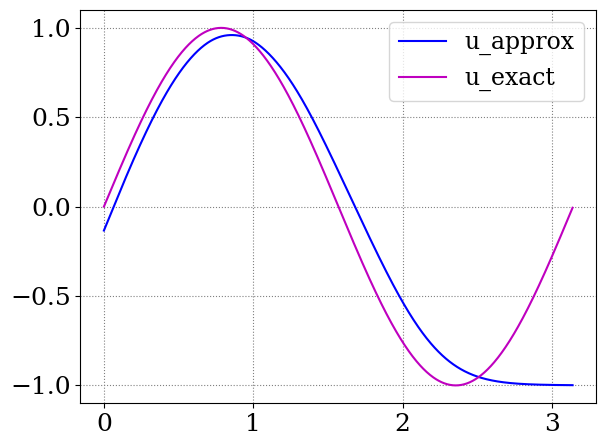

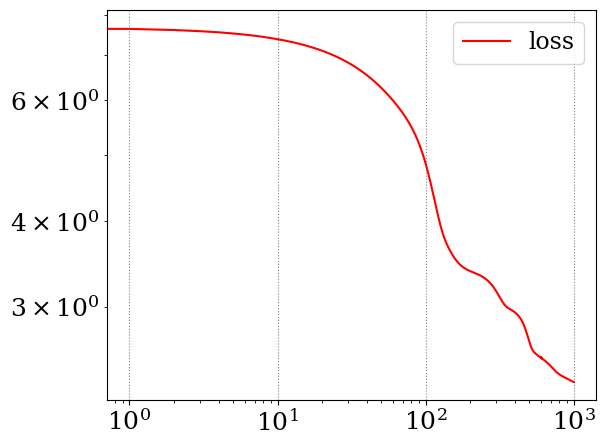

In [2]:
## ----------------------------------------------------------------------------
#   Plot the results
## ----------------------------------------------------------------------------

from matplotlib import rcParams


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['legend.fontsize'] = 17
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.labelsize'] = 19

# Exact solution
def exact_u(x):
    return keras.ops.sin(2 * x)

# Generate a list of x values for visualization
xlist = jnp.array([jnp.pi/1000 * i for i in range(1000)])

## ---------
# SOLUTION
## ---------

fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(xlist, u_model(xlist), color='b')
plt.plot(xlist, exact_u(xlist), color='m')

plt.legend(['u_approx', 'u_exact'])

ax.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.show()


## ---------
# Loss evolution
## ---------

fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(history.history['loss'], color='r')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(['loss'])

ax.grid(which = 'major', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.show()
